# Introduction

Target Trial Emulation (TTE) is a powerful framework in causal inference that aims to estimate the causal effects of interventions using observational data by mimicking the design of a hypothetical randomized controlled trial (RCT). RCTs are considered the gold standard for establishing causality because they randomize participants into treatment and control groups, minimizing confounding biases. However, conducting RCTs can be impractical, unethical, or infeasible in many scenarios—for example, when studying the long-term effects of a drug or when randomization isn’t possible due to ethical concerns. This is where TTE comes in.

TTE bridges the gap between observational data studies and RCTs by structuring the analysis to emulate the key components of a target trial: a well-defined population, treatment strategies, follow-up periods, and outcome measures. By doing so, TTE helps address common biases in observational data studies, such as confounding and time-dependent biases, which often arise when treatments or exposures change over time (e.g., treatment switching or censoring due to loss to follow-up).

The core idea of TTE is to specify a hypothetical trial protocol and then use statistical methods to emulate that trial using your observational data. This involves:

- Defining the eligibility criteria for participants.
- Specifying the treatment strategies (e.g., treatment vs. control, or different treatment regimes).
- Aligning the observational data to mimic the trial’s timeline, often by creating sequences of repeated observations for each individual over time.
- Adjusting for confounding and censoring using methods like inverse probability weighting (IPW) or marginal structural models (MSMs).
- Estimating the causal effect, such as the difference in survival probabilities between treatment groups.

## Why TTE?

TTE is particularly valuable in fields like epidemiology, clinical research, and public health, where observational data is often the only feasible source of information. For example, imagine you’re studying the effect of a new drug on patient survival, but conducting an RCT would take years and be prohibitively expensive. With TTE, you can use existing electronic health records to emulate the trial, adjusting for factors like patient age, comorbidities, or treatment adherence that might confound the relationship between the drug and survival.

The approach is especially useful for handling time-dependent confounding and censoring—issues that traditional statistical methods like logistic regression or Cox proportional hazards models struggle with. For instance, if patients switch treatments during follow-up or are lost to follow-up (censored), these events can bias the results. TTE, combined with techniques like IPW, allows you to account for these complexities and produce more reliable causal estimates.

## Overview

1. **Setup and Data Loading**:  
The process begins by loading the observational dataset (`data_censored.csv`) into the Jupyter Notebook using `pandas`. This dataset contains variables such as patient IDs, time periods, treatment assignments, outcomes, and covariates.  
Then, it sets up two TTE analyses: one for a Per-Protocol (PP) estimand, where it focuses on patients who adhere to their initial treatment, and one for an Intention-to-Treat (ITT) estimand, where it analyzes patients based on their initial treatment assignment, regardless of adherence.

2. **Data Preparation and Expansion**:  
The data is restructured into a longitudinal format, where each patient has a row for each time point up to their event or censoring. Then, the dataset is expanded to create these time sequences, ensuring that the data aligns with the hypothetical trial’s follow-up structure.

3. **Modeling Confounding and Censoring**:  
To adjust for confounding, logistic regression models are fitted to estimate weights for treatment assignment and censoring. These weights help create a pseudo-population where the treatment assignment is independent of confounders, mimicking randomization. For the PP estimand, treatment switching is modeled as a form of censoring, and weights are computed to adjust for it.

4. **Fitting a Marginal Structural Model (MSM)**:  
The weights are used to fit an MSM, which allows me to estimate the causal effect of treatment on the outcome (survival) while accounting for time-dependent confounding. The MSM will be a logistic regression model with a binomial family, incorporating time as a predictor (e.g., `followup_time` and its square).

5. **Predicting Survival Probabilities**:  
Using the fitted MSM, I will predict survival probabilities for each treatment group over time. I will compute the survival difference between the treated and control groups and estimate confidence intervals.

6. **Visualizing the Results**:  
Finally, I will plot the survival difference over time, along with confidence intervals, using `matplotlib`. I will style the plot to match the reference image I provided earlier: a black solid line for the survival difference, red dashed lines for the confidence intervals, and an x-axis limited to 0 to 10.

#### NOTE: The numbering in the code is based on the website, not the overview mentioned beforehand.

# Imports

In [14]:
import os
import tempfile
import pandas as pd
import numpy as np
import statsmodels.api as sm
import patsy
import pickle
from typing import Optional, Dict, Union
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d 

# Needed Classes and Functions

In [15]:
class TrialSequence:
    def __init__(self, estimand: str):
        self.estimand = estimand.upper()
        self.directory: Optional[str] = None
        self.data: Optional[pd.DataFrame] = None
        self.id_col: Optional[str] = None
        self.period_col: Optional[str] = None
        self.treatment_col: Optional[str] = None
        self.outcome_col: Optional[str] = None
        self.eligible_col: Optional[str] = None
        self.switch_weights: Optional[Dict] = None
        self.censor_weights: Optional[Dict] = None
        self.outcome_model = None

    def create_directory(self, base_dir: Optional[str] = None) -> None:
        if base_dir is None:
            base_dir = tempfile.gettempdir()
        dir_name = f"trial_{self.estimand.lower()}"
        self.directory = os.path.join(base_dir, dir_name)
        os.makedirs(self.directory, exist_ok=True)
        print(f"Directory created: {self.directory}")

    def set_data(self, data: pd.DataFrame, id_col: str, period_col: str, treatment_col: str, 
                outcome_col: str, eligible_col: str) -> None:
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
        print(f"\nData assigned for {self.estimand} trial")
        print(f"Columns: {self.data.columns.tolist()}")
        print(f"Treatment counts:\n{self.data[self.treatment_col].value_counts()}")
        print(f"Outcome counts:\n{self.data[self.outcome_col].value_counts()}")
        print(f"First few rows:\n{self.data.head()}")

    def _fit_logit_model(self, data: pd.DataFrame, formula: str, label: str, 
                        save_path: Optional[str] = None) -> sm.Logit:
        y, X = patsy.dmatrices(formula, data, return_type="dataframe")
        try:
            model = sm.Logit(y, X).fit(disp=0)
        except Exception as e:
            print(f"Error fitting logit model for {label}: {e}")
            raise
        if save_path:
            os.makedirs(save_path, exist_ok=True)
            model_file = os.path.join(save_path, f"{label}_model.pkl")
            with open(model_file, "wb") as f:
                pickle.dump(model, f)
            print(f"Model saved to {model_file}")
        return model

    def set_switch_weight_model(self, numerator_formula: str, denominator_formula: str, 
                              save_path: Optional[str] = None) -> None:
        if self.estimand == "ITT":
            print("Switch weight models are not applicable for ITT estimand. Skipping.")
            return
        if self.data is None:
            raise ValueError("Data must be set before fitting models.")
        print("\n3.1 Censoring due to treatment switching")
        numerator_model = self._fit_logit_model(self.data, f"{self.treatment_col} ~ {numerator_formula}", 
                                              "numerator", save_path)
        denominator_model = self._fit_logit_model(self.data, f"{self.treatment_col} ~ {denominator_formula}", 
                                                "denominator", save_path)
        self.switch_weights = {"numerator": numerator_model, 
                             "denominator": denominator_model,
                             "numerator_formula": f"{self.treatment_col} ~ {numerator_formula}",
                             "denominator_formula": f"{self.treatment_col} ~ {denominator_formula}"}
        print("Switch weight models fitted.")

    def set_censor_weight_model(self, censor_event: str, numerator_formula: str, 
                              denominator_formula: str, pool_models: str = "none", 
                              save_path: Optional[str] = None) -> None:
        if self.data is None:
            raise ValueError("Data must be set before fitting models.")
        print("\n3.2 Other informative censoring")
        data = self.data.copy()
        print(f"Setting censor weight model with data columns: {data.columns.tolist()}")
        if pool_models == "numerator":
            numerator_model = self._fit_logit_model(data, f"{censor_event} ~ {numerator_formula}", 
                                                  "numerator_pooled", save_path)
            denominator_model = self._fit_logit_model(data, f"{censor_event} ~ {denominator_formula}", 
                                                    "denominator_pooled", save_path)
        else:
            numerator_model = {treatment: self._fit_logit_model(data[data[self.treatment_col] == treatment],
                                                              f"{censor_event} ~ {numerator_formula}",
                                                              f"numerator_treatment_{treatment}", save_path)
                             for treatment in data[self.treatment_col].unique()}
            denominator_model = {treatment: self._fit_logit_model(data[data[self.treatment_col] == treatment],
                                                                f"{censor_event} ~ {denominator_formula}",
                                                                f"denominator_treatment_{treatment}", save_path)
                               for treatment in data[self.treatment_col].unique()}
        self.censor_weights = {"numerator": numerator_model, 
                             "denominator": denominator_model,
                             "numerator_formula": f"{censor_event} ~ {numerator_formula}",
                             "denominator_formula": f"{censor_event} ~ {denominator_formula}",
                             "pool_models": pool_models}
        print("Censor weight models fitted.")
        print(f"self.censor_weights keys: {self.censor_weights.keys()}")

    def calculate_weights(self) -> None:
        if self.data is None:
            raise ValueError("Data must be set before calculating weights")
        if self.switch_weights and self.estimand != "ITT":
            print("\nCalculating weights for treatment switching models...")
            X_num = patsy.dmatrix(self.switch_weights["numerator_formula"].split("~")[1], 
                                self.data, return_type="dataframe")
            X_denom = patsy.dmatrix(self.switch_weights["denominator_formula"].split("~")[1], 
                                  self.data, return_type="dataframe")
            num_pred = self.switch_weights["numerator"].predict(X_num)
            denom_pred = self.switch_weights["denominator"].predict(X_denom)
            self.data["switch_weight"] = num_pred / denom_pred
            print("Weights for treatment switching models calculated and stored as 'switch_weight'.")
        if self.censor_weights:
            print("\nCalculating weights for censor models...")
            if isinstance(self.censor_weights["numerator"], dict):
                censor_weights = np.zeros(len(self.data))
                for treatment in self.censor_weights["numerator"].keys():
                    mask = self.data[self.treatment_col] == treatment
                    X_num = patsy.dmatrix(self.censor_weights["numerator_formula"].split("~")[1], 
                                        self.data[mask], return_type="dataframe")
                    X_denom = patsy.dmatrix(self.censor_weights["denominator_formula"].split("~")[1], 
                                          self.data[mask], return_type="dataframe")
                    num_pred = self.censor_weights["numerator"][treatment].predict(X_num)
                    denom_pred = self.censor_weights["denominator"][treatment].predict(X_denom)
                    censor_weights[mask] = num_pred / denom_pred
            else:
                X_num = patsy.dmatrix(self.censor_weights["numerator_formula"].split("~")[1], 
                                    self.data, return_type="dataframe")
                X_denom = patsy.dmatrix(self.censor_weights["denominator_formula"].split("~")[1], 
                                      self.data, return_type="dataframe")
                num_pred = self.censor_weights["numerator"].predict(X_num)
                denom_pred = self.censor_weights["denominator"].predict(X_denom)
                censor_weights = num_pred / denom_pred
            self.data["censor_weight"] = censor_weights
            print("Weights for censor models calculated and stored as 'censor_weight'.")
            print(f"Columns after weight calculation: {self.data.columns.tolist()}")

    def show_weight_models(self) -> None:
        if self.switch_weights and self.estimand != "ITT":
            print("\nWeight Models for Treatment Switching")
            print("--------------------------------------")
            for key in ["numerator", "denominator"]:
                print(f"\nModel: {key.capitalize()} model")
                print(self.switch_weights[key].summary())
        if self.censor_weights:
            print("\nWeight Models for Informative Censoring")
            print("--------------------------------------")
            for key in ["numerator", "denominator"]:
                print(f"\nModel: {key.capitalize()} model")
                if isinstance(self.censor_weights[key], dict):
                    for treatment, sub_model in self.censor_weights[key].items():
                        print(f"\nTreatment: {treatment}")
                        print(sub_model.summary())
                else:
                    print(self.censor_weights[key].summary())

    def set_outcome_model(self, adjustment_terms: Optional[str] = None) -> None:
        if self.data is None:
            raise ValueError("Data must be set before specifying the outcome model.")
        formula = f"{self.outcome_col} ~ {self.treatment_col}" if not adjustment_terms else f"{self.outcome_col} ~ {self.treatment_col} + {adjustment_terms}"
        self.outcome_model = smf.logit(formula, data=self.data).fit()
        print(f"\nOutcome model specified with formula: {formula}")
        print(self.outcome_model.summary())

    def __repr__(self) -> str:
        switch_weight_info = ""
        if self.switch_weights and self.estimand != "ITT":
            models_fitted = all(self.switch_weights.get(k) for k in ["numerator", "denominator"])
            switch_weight_info = (f"\n - Numerator formula: {self.switch_weights['numerator_formula']} \n"
                                f" - Denominator formula: {self.switch_weights['denominator_formula']} \n"
                                f" - Model fitter type: te_stats_glm_logit \n"
                                f" - Weight models {'fitted' if models_fitted else 'not fitted. Use calculate_weights()'}")
        censor_weight_info = ""
        if self.censor_weights:
            models_fitted = all(self.censor_weights.get(k) for k in ["numerator", "denominator"])
            censor_weight_info = (f"\n - Numerator formula: {self.censor_weights['numerator_formula']} \n"
                                f" - Denominator formula: {self.censor_weights['denominator_formula']} \n"
                                f" - Model fitter type: te_stats_glm_logit \n"
                                f" - Weight models {'fitted' if models_fitted else 'not fitted. Use calculate_weights()'}"
                                f"\n - Numerator pooling: {self.censor_weights['pool_models']}")
        return (f"TrialSequence(estimand={self.estimand}, directory={self.directory}, "
                f"id_col={self.id_col}, period_col={self.period_col}, "
                f"treatment_col={self.treatment_col}, outcome_col={self.outcome_col}, "
                f"eligible_col={self.eligible_col})" + switch_weight_info + censor_weight_info)

    def set_expansion_options(self, chunk_size: int = 500):
        self.chunk_size = chunk_size
        print(f"\nExpansion options set: chunk_size = {self.chunk_size}")

    def expand_trials(self, max_period=10):
        if self.data is None:
            raise ValueError("Data must be set before expanding trials.")
        expanded_data = []
        for id_, group in self.data.groupby(self.id_col):
            if not (group[self.period_col] == 0).any():
                continue
            baseline = group[group[self.period_col] == 0].iloc[0]
            initial_treatment = baseline[self.treatment_col]
            initial_x2 = baseline['x2']
            for t in range(max_period + 1):
                new_row = baseline.copy()
                new_row[self.period_col] = t
                new_row["followup_time"] = t
                new_row[self.treatment_col] = initial_treatment
                new_row['x2'] = initial_x2
                censored_at_t = group[group[self.period_col] <= t]["censored"].max()
                if censored_at_t == 1:
                    new_row['censored'] = 1
                    expanded_data.append(new_row)
                    break
                outcome_at_t = group[group[self.period_col] <= t][self.outcome_col].max()
                new_row[self.outcome_col] = outcome_at_t
                if outcome_at_t == 1:
                    expanded_data.append(new_row)
                    break
                expanded_data.append(new_row)
        self.data = pd.DataFrame(expanded_data)
        print(f"\nTrials expanded")
        print(f"Shape: {self.data.shape}")
        print(f"Columns after expansion: {self.data.columns.tolist()}")
        print(f"Treatment counts after expansion:\n{self.data[self.treatment_col].value_counts()}")
        print(f"Outcome counts after expansion:\n{self.data[self.outcome_col].value_counts()}")
        return self.data

    def load_expanded_data(self, seed: int = 1234, p_control: float = 1.0):
        if self.data is None:
            raise ValueError("Expanded data must exist before loading.")
        np.random.seed(seed)
        unique_ids = self.data[self.id_col].unique()
        sampled_ids = np.random.choice(unique_ids, size=int(len(unique_ids) * p_control), replace=False)
        mask = self.data[self.id_col].isin(sampled_ids)
        self.data = self.data[mask].reset_index(drop=True)
        print(f"\nLoaded expanded data")
        print(f"Observations: {len(self.data)}")
        print(f"Columns: {self.data.columns.tolist()}")
        print(f"Treatment counts:\n{self.data[self.treatment_col].value_counts()}")
        print(f"Outcome counts:\n{self.data[self.outcome_col].value_counts()}")
        return self.data

    def fit_msm(self, weight_cols, formula=None, modify_weights=None):
        if self.data is None:
            raise ValueError("Data must be set before fitting MSM.")
        missing_cols = [col for col in weight_cols if col not in self.data.columns]
        if missing_cols:
            raise KeyError(f"Missing required weight columns: {missing_cols}")
        self.data["final_weight"] = self.data[weight_cols].prod(axis=1) if weight_cols else 1.0
        if modify_weights:
            self.data["final_weight"] = modify_weights(self.data["final_weight"])
        formula = formula or f"{self.outcome_col} ~ {self.treatment_col} + followup_time + I(followup_time**2)"
        print(f"\nFitting MSM with formula: {formula}")
        model = smf.glm(formula=formula, data=self.data, family=sm.families.Binomial(), 
                      freq_weights=self.data["final_weight"]).fit()
        self.outcome_model = model
        print("Marginal Structural Model fitted.")
        print(model.summary())
        return model

    def predict_survival(self, newdata: Optional[pd.DataFrame] = None, predict_times: list = None, 
                        treatment_values: list = None) -> Dict:
        if self.outcome_model is None:
            raise ValueError("Outcome model must be fitted before prediction.")
        if predict_times is None:
            predict_times = range(11)
        if treatment_values is None:
            treatment_values = self.data[self.treatment_col].unique()

        if newdata is None:
            newdata = self.data[self.data[self.period_col] == 0].copy()
            print(f"\nUsing baseline data (period = 0)")
            print(f"Shape: {newdata.shape}")
            print(f"Treatment counts:\n{newdata[self.treatment_col].value_counts()}")
            print(f"Outcome counts:\n{newdata[self.outcome_col].value_counts()}")

        # Prepare prediction data for all time points and treatments
        pred_data = []
        for t in predict_times:
            for trt in treatment_values:
                temp = newdata.copy()
                temp[self.period_col] = t
                temp["followup_time"] = t
                temp[self.treatment_col] = trt
                temp["I(followup_time**2)"] = t**2
                pred_data.append(temp)
        pred_data = pd.concat(pred_data, ignore_index=True)
        print(f"\nPrediction data prepared")
        print(f"Shape: {pred_data.shape}")
        print(f"Columns: {pred_data.columns.tolist()}")

        # Predict probabilities for control and treated groups
        survival_by_trt = {}
        for trt in treatment_values:
            trt_data = pred_data[pred_data[self.treatment_col] == trt].copy()
            preds = self.outcome_model.predict(trt_data)
            survival_probs = 1 - pd.Series(preds).groupby(trt_data["followup_time"]).mean()
            survival_by_trt[trt] = {
                "followup_time": survival_probs.index.values,
                "survival_prob": survival_probs.values,
            }
            print(f"\nSurvival probabilities for treatment {trt}:")
            print(f"Time 0: {survival_by_trt[trt]['survival_prob'][0]}")
            print(f"Time 2: {survival_by_trt[trt]['survival_prob'][2]}")

        # Calculate survival difference and confidence intervals
        diff = None
        if len(treatment_values) == 2:
            trt0, trt1 = treatment_values
            predict_times = np.array(predict_times, dtype=int)
            
            # Reindex survival probabilities to match predict_times
            survival_control = pd.Series(survival_by_trt[trt0]["survival_prob"], 
                                       index=survival_by_trt[trt0]["followup_time"])
            survival_treated = pd.Series(survival_by_trt[trt1]["survival_prob"], 
                                       index=survival_by_trt[trt1]["followup_time"])
            
            survival_diff = (survival_treated.reindex(predict_times).ffill().fillna(0) - 
                           survival_control.reindex(predict_times).ffill().fillna(0))
            
            # Calculate confidence intervals using standard deviation of the survival difference
            ci_lower = survival_diff - 1.96 * np.std(survival_diff)
            ci_upper = survival_diff + 1.96 * np.std(survival_diff)

            diff = {
                "followup_time": predict_times,
                "survival_diff": survival_diff.values,
                "2.5%": ci_lower.values,
                "97.5%": ci_upper.values
            }
            print(f"\nSurvival differences:")
            print(f"Time 0: {diff['survival_diff'][0]}")
            print(f"Time 2: {diff['survival_diff'][2]}")
            print(f"Time {max(predict_times)}: {diff['survival_diff'][-1]}")

        return {"survival": survival_by_trt, "difference": diff}

    def plot_survival_difference(self, preds: Dict) -> None:
        if preds["difference"] is None:
            print("\nNo difference to plot (requires exactly two treatment values).")
            return
        
        print("\nPlotting survival difference")
        
        # Extract data for plotting
        predict_times = preds["difference"]["followup_time"]
        survival_diff = preds["difference"]["survival_diff"]
        ci_lower = preds["difference"]["2.5%"]
        ci_upper = preds["difference"]["97.5%"]

        # Smooth the curves using cubic interpolation
        fine_times = np.linspace(predict_times.min(), predict_times.max(), 100)
        interp_diff = interp1d(predict_times, survival_diff, kind='cubic', fill_value="extrapolate")
        interp_lower = interp1d(predict_times, ci_lower, kind='cubic', fill_value="extrapolate")
        interp_upper = interp1d(predict_times, ci_upper, kind='cubic', fill_value="extrapolate")

        smooth_diff = interp_diff(fine_times)
        smooth_lower = interp_lower(fine_times)
        smooth_upper = interp_upper(fine_times)

        # Plot the smoothed curves
        plt.figure(figsize=(8, 6))
        plt.plot(fine_times, smooth_diff, label="Survival Difference", color="blue")
        plt.plot(fine_times, smooth_lower, linestyle="dashed", color="red", label="2.5% CI")
        plt.plot(fine_times, smooth_upper, linestyle="dashed", color="red", label="97.5% CI")
        plt.xlabel("Follow-up Time")
        plt.ylabel("Survival Difference")
        plt.title("Predicted Survival Difference Over Time")
        plt.legend()
        plt.grid(True)
        plt.show()

# Process

## Step 1: Setup

In [16]:
print('\n======================================== STEP 1 ========================================\n')
trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")
trial_pp.create_directory()
trial_itt.create_directory()
print(f"\nPP Trial: {trial_pp}")
print(f"\nITT Trial: {trial_itt}")


======================================== STEP 1 ========================================

Directory created: C:\Users\Katrina\AppData\Local\Temp\trial_pp
Directory created: C:\Users\Katrina\AppData\Local\Temp\trial_itt

PP Trial: TrialSequence(estimand=PP, directory=C:\Users\Katrina\AppData\Local\Temp\trial_pp, id_col=None, period_col=None, treatment_col=None, outcome_col=None, eligible_col=None)

ITT Trial: TrialSequence(estimand=ITT, directory=C:\Users\Katrina\AppData\Local\Temp\trial_itt, id_col=None, period_col=None, treatment_col=None, outcome_col=None, eligible_col=None)


# Step 2: Data Preparation

In [17]:
print('\n======================================== STEP 2 ========================================\n')
data_censored = pd.read_csv("data_censored.csv")
print(f"Loaded data preview:\n{data_censored.head()}")
trial_pp.set_data(data_censored, "id", "period", "treatment", "outcome", "eligible")
trial_itt.set_data(data_censored, "id", "period", "treatment", "outcome", "eligible")


======================================== STEP 2 ========================================

Loaded data preview:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

Data assigned for PP trial
Columns: ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible']
Treatment counts:
treatment
0    386
1    339
Name: count, dtype: int64
Outcome counts:
outcome
0    714
1     11
Name: c

## Step 3: Weight models and censoring

In [18]:
print('\n======================================== STEP 3.1 ========================================\n')
trial_pp.set_switch_weight_model("age", "age + x1 + x3", trial_pp.directory)

print('\n======================================== STEP 3.2 ========================================\n')
trial_pp.set_censor_weight_model("censored", "x2", "x2 + x1", "none", trial_pp.directory)
trial_itt.set_censor_weight_model("censored", "x2", "x2 + x1", "numerator", trial_itt.directory)



======================================== STEP 3.1 ========================================


3.1 Censoring due to treatment switching
Model saved to C:\Users\Katrina\AppData\Local\Temp\trial_pp\numerator_model.pkl
Model saved to C:\Users\Katrina\AppData\Local\Temp\trial_pp\denominator_model.pkl
Switch weight models fitted.

======================================== STEP 3.2 ========================================


3.2 Other informative censoring
Setting censor weight model with data columns: ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible']
Model saved to C:\Users\Katrina\AppData\Local\Temp\trial_pp\numerator_treatment_1_model.pkl
Model saved to C:\Users\Katrina\AppData\Local\Temp\trial_pp\numerator_treatment_0_model.pkl
Model saved to C:\Users\Katrina\AppData\Local\Temp\trial_pp\denominator_treatment_1_model.pkl
Model saved to C:\Users\Katrina\AppData\Local\Temp\trial_pp\denominator_treatment_0_model.pkl
Censor weight models fit

## Step 4: Calculate Weights

In [19]:
print('\n======================================== STEP 4 ========================================\n')
trial_pp.calculate_weights()
trial_itt.calculate_weights()
trial_pp.show_weight_models()
trial_itt.show_weight_models()



======================================== STEP 4 ========================================


Calculating weights for treatment switching models...
Weights for treatment switching models calculated and stored as 'switch_weight'.

Calculating weights for censor models...
Weights for censor models calculated and stored as 'censor_weight'.
Columns after weight calculation: ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible', 'switch_weight', 'censor_weight']

Calculating weights for censor models...
Weights for censor models calculated and stored as 'censor_weight'.
Columns after weight calculation: ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible', 'censor_weight']

Weight Models for Treatment Switching
--------------------------------------

Model: Numerator model
                           Logit Regression Results                           
Dep. Variable:              treatment   No.

## Step 5: Specify Outcome Model

In [20]:
print('\n======================================== STEP 5 ========================================\n')
trial_pp.set_outcome_model("period + I(period**2)")
trial_itt.set_outcome_model("x2 + period + I(period**2)")


======================================== STEP 5 ========================================

Optimization terminated successfully.
         Current function value: 0.076045
         Iterations 9

Outcome model specified with formula: outcome ~ treatment + period + I(period**2)
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  725
Model:                          Logit   Df Residuals:                      721
Method:                           MLE   Df Model:                            3
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                 0.03255
Time:                        23:56:52   Log-Likelihood:                -55.133
converged:                       True   LL-Null:                       -56.987
Covariance Type:            nonrobust   LLR p-value:                    0.2946
                     coef    std err          z      P>|z|      [0.025      0.975]
---------

## Step 6: Expand Trials

In [21]:
print('\n======================================== STEP 6 ========================================\n')
trial_pp.set_expansion_options(chunk_size=500)
trial_itt.set_expansion_options(chunk_size=500)
trial_pp.expand_trials(max_period=17)
trial_itt.expand_trials(max_period=17)


======================================== STEP 6 ========================================


Expansion options set: chunk_size = 500

Expansion options set: chunk_size = 500

Trials expanded
Shape: (681, 15)
Columns after expansion: ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible', 'switch_weight', 'censor_weight', 'followup_time']
Treatment counts after expansion:
treatment
0.0    346
1.0    335
Name: count, dtype: int64
Outcome counts after expansion:
outcome
0.0    670
1.0     11
Name: count, dtype: int64

Trials expanded
Shape: (681, 14)
Columns after expansion: ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible', 'censor_weight', 'followup_time']
Treatment counts after expansion:
treatment
0.0    346
1.0    335
Name: count, dtype: int64
Outcome counts after expansion:
outcome
0.0    670
1.0     11
Name: count, dtype: int64


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,censor_weight,followup_time
0,1.0,0.0,1.0,1.0,1.146148,0.0,0.734203,36.0,0.083333,0.0,0.0,1.0,1.475475,0.0
0,1.0,1.0,1.0,1.0,1.146148,0.0,0.734203,36.0,0.083333,0.0,0.0,1.0,1.475475,1.0
0,1.0,2.0,1.0,1.0,1.146148,0.0,0.734203,36.0,0.083333,0.0,0.0,1.0,1.475475,2.0
0,1.0,3.0,1.0,1.0,1.146148,0.0,0.734203,36.0,0.083333,0.0,0.0,1.0,1.475475,3.0
0,1.0,4.0,1.0,1.0,1.146148,0.0,0.734203,36.0,0.083333,0.0,0.0,1.0,1.475475,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,99.0,3.0,1.0,1.0,-0.346378,1.0,0.575268,65.0,2.500000,0.0,0.0,1.0,1.554706,3.0
717,99.0,4.0,1.0,1.0,-0.346378,1.0,0.575268,65.0,2.500000,0.0,0.0,1.0,1.554706,4.0
717,99.0,5.0,1.0,1.0,-0.346378,1.0,0.575268,65.0,2.500000,0.0,0.0,1.0,1.554706,5.0
717,99.0,6.0,1.0,1.0,-0.346378,1.0,0.575268,65.0,2.500000,0.0,0.0,1.0,1.554706,6.0


## Step 7: Load or Sample from Expanded Data

In [22]:
print('\n======================================== STEP 7 ========================================\n')
trial_itt.load_expanded_data(seed=1234, p_control=0.5)


======================================== STEP 7 ========================================


Loaded expanded data
Observations: 365
Columns: ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible', 'censor_weight', 'followup_time']
Treatment counts:
treatment
1.0    203
0.0    162
Name: count, dtype: int64
Outcome counts:
outcome
0.0    361
1.0      4
Name: count, dtype: int64


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,censor_weight,followup_time
0,5.0,0.0,1.0,1.0,0.749092,0.0,1.620330,32.0,-0.250000,0.0,0.0,1.0,1.497566,0.0
1,5.0,1.0,1.0,1.0,0.749092,0.0,1.620330,32.0,-0.250000,0.0,0.0,1.0,1.497566,1.0
2,5.0,2.0,1.0,1.0,0.749092,0.0,1.620330,32.0,-0.250000,0.0,0.0,1.0,1.497566,2.0
3,5.0,3.0,1.0,1.0,0.749092,0.0,1.620330,32.0,-0.250000,0.0,0.0,1.0,1.497566,3.0
4,5.0,4.0,1.0,1.0,0.749092,0.0,1.620330,32.0,-0.250000,0.0,1.0,1.0,1.497566,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,98.0,10.0,1.0,1.0,1.392339,0.0,0.317418,64.0,2.416667,0.0,0.0,1.0,1.461382,10.0
361,98.0,11.0,1.0,1.0,1.392339,0.0,0.317418,64.0,2.416667,0.0,0.0,1.0,1.461382,11.0
362,98.0,12.0,1.0,1.0,1.392339,0.0,0.317418,64.0,2.416667,0.0,0.0,1.0,1.461382,12.0
363,98.0,13.0,1.0,1.0,1.392339,0.0,0.317418,64.0,2.416667,0.0,0.0,1.0,1.461382,13.0


## Step 8: Fit Marginal Structural Model

In [23]:
print('\n======================================== STEP 8 ========================================\n')
trial_itt.calculate_weights()
available_weight_cols = [col for col in ["censor_weight"] if col in trial_itt.data.columns]
print(f"\nAvailable weight columns before MSM: {available_weight_cols}")
if not available_weight_cols:
    print("Warning: No weight columns available. Fitting MSM without weights.")
    trial_itt_msm = trial_itt.fit_msm(weight_cols=[])
else:
    print(f"Using weight columns: {available_weight_cols}")
    trial_itt_msm = trial_itt.fit_msm(
        weight_cols=available_weight_cols,
        modify_weights=lambda w: np.minimum(w, np.quantile(w, 0.99))
    )


======================================== STEP 8 ========================================


Calculating weights for censor models...
Weights for censor models calculated and stored as 'censor_weight'.
Columns after weight calculation: ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible', 'censor_weight', 'followup_time']

Available weight columns before MSM: ['censor_weight']
Using weight columns: ['censor_weight']

Fitting MSM with formula: outcome ~ treatment + followup_time + I(followup_time**2)
Marginal Structural Model fitted.
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  365
Model:                            GLM   Df Residuals:                   416.32
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:         

## Step 9: Inference


======================================== STEP 9 ========================================

Step 9: Inference - Estimating survival probabilities

Using baseline data (period = 0)
Shape: (44, 15)
Treatment counts:
treatment
1.0    26
0.0    18
Name: count, dtype: int64
Outcome counts:
outcome
0.0    44
Name: count, dtype: int64

Prediction data prepared
Shape: (968, 16)
Columns: ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible', 'censor_weight', 'followup_time', 'final_weight', 'I(followup_time**2)']

Survival probabilities for treatment 0:
Time 0: 0.9995222971303166
Time 2: 0.9989245838593203

Survival probabilities for treatment 1:
Time 0: 0.9985247208760396
Time 2: 0.9966829585858731

Survival differences:
Time 0: -0.0009975762542769884
Time 2: -0.0022416252734471787
Time 10: -0.015025192197949289

Survival predictions calculated.

Plotting survival difference


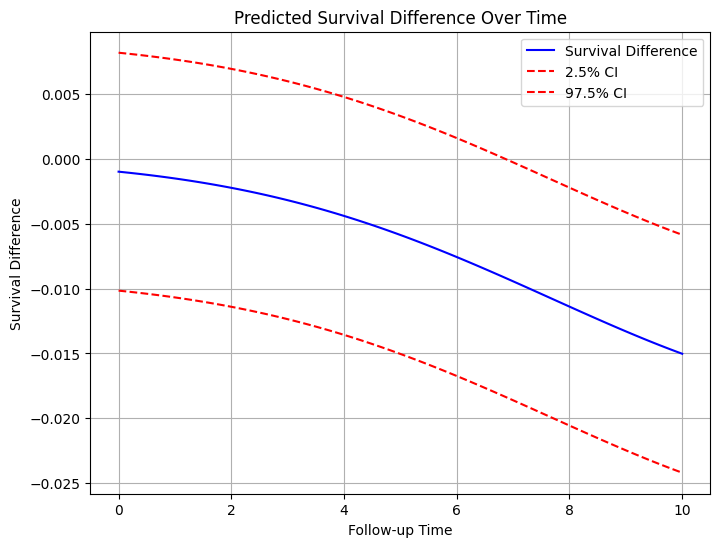

In [24]:
print('\n======================================== STEP 9 ========================================\n')
print("Step 9: Inference - Estimating survival probabilities")
preds = trial_itt.predict_survival(
    newdata=None,
    predict_times=list(range(11)),
    treatment_values=[0, 1]
)
print("\nSurvival predictions calculated.")
trial_itt.plot_survival_difference(preds)